In [1]:
%matplotlib inline

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from pylab import *

# 概率生成模型

首先考虑二分类情况，类别C1的后验概率可以写成：

$$p(C_1|x)=\frac{p(x|C_1)p(C_1)}{p(x|C_1)p(C_1)+p(x|C_2)p(C_2)}=\frac{1}{1+\exp(-a)}=\sigma(a)$$

其中，$a=ln\frac{p(x|C_1)p(C_1)}{p(x|C_2)p(C_2)}$

$\sigma(a)$是logistic sigmoid函数，定义为

$\sigma(a)=\frac{1}{1+\exp(-a)}$

sigmoid函数图形为s形，其满足下面这几个性质：

$\sigma(-a)=\sigma(a)$

其反函数为

$a=ln(\frac{\sigma}{1-\sigma})$,它表示两个类别的概率比值的对数：

 $ln\frac{p(C_1|x)}{p(C_2|x)}$

我们从simoid函数的定义可以看出，$p(C_2|x)=\sigma(-a)$

所以有   $p(C_1|x)+p(C_2|x)=1$


In [3]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

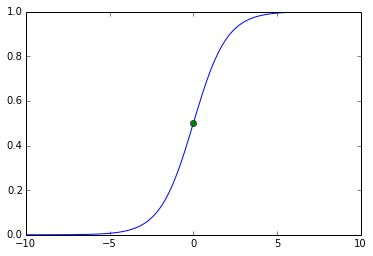

In [4]:
x=np.arange(-10,10,0.01)
y=sigmoid(x)
plt.plot(x,y)
plt.plot(0,0.5,'go')
plt.show()

# 多分类情况

$p(C_k|x)= \frac{p(x|C_k)p(C_k)}{ \sum_j  p(x|C_k)p(C_k)} 
            = \frac{exp(a_k)}{\sum_j exp(a_j)}$

其中$a_k=lnp(x|C_k)p(C_k)$

上述函数被称为归一化指数（normalized exponential），也被称为softmax函数,因为它表示“max”函数的一个平滑版本。这是因为,如果对于所有的
 $j\neq k$都有$a_k >> a_j$,那么$p(C_k|x)≃1$且$p(Cj|x)≃0$。


/Library/Python/2.7/site-packages/ipykernel/__main__.py:66: RuntimeWarning: divide by zero encountered in double_scalars


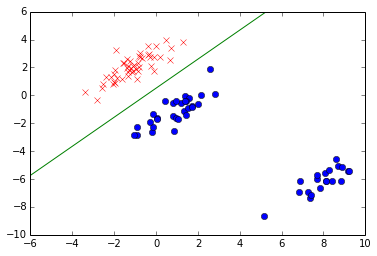

In [5]:
N=100
def f(x1, w):
    # 决策边界的直线方程
    # p(C1|X) > 0.5 -> X属于类别C1
    # p(C1|X) < 0.5 -> X属于类别C2
    # p(C1|X) = 0.5 -> sigmoid函数的输入为0
    a = - (w[1] / w[2])
    b = - (w[0] / w[2])
    return a * x1 + b

# 生成训练数据
cls1 = []
cls2 = []

mean1 = [-1, 2]
mean2 = [1, -1]
mean3 = [8, -6]
cov = [[1.0,0.8], [0.8,1.0]]

# 假设数据服从多维高斯分布
cls1.extend(np.random.multivariate_normal(mean1, cov, N / 2))
cls2.extend(np.random.multivariate_normal(mean2, cov, N / 2 - 20))
cls2.extend(np.random.multivariate_normal(mean3, cov, 20))

# 创建输入矩阵X
temp = vstack((cls1, cls2))
temp2 = ones((N, 1))
X = hstack((temp2, temp))

# 创建target矩阵T(注意这里不是1-of-K的表示方法)
t = []
for i in range(N / 2):
    t.append(1.0)
for i in range(N / 2):
    t.append(0.0)
t = array(t)

# 用IRLS方法更新参数w
turn = 0
w = array([0.0, 0.0, 0.0])  # 为参数w设定适当的初始值
while True:
    # 计算 phi 由于没有使用固定的基函数，phi恒等于输入矩阵X
    phi = X

    # 计算R和Y
    R = np.zeros((N, N))
    y = []
    for n in range(N):

        # a=W^T\phi
        a = np.dot(w, phi[n,])  
        y_n = sigmoid(a)
        # R 是一个对角矩阵
        R[n, n] = y_n * (1 - y_n)
        y.append(y_n)

    # 计算海森（Hessian）矩阵H
    phi_T = phi.T
    H = np.dot(phi_T, np.dot(R, phi))

    # 更新参数W
    w_new = w - np.dot(np.linalg.inv(H), np.dot(phi_T, y-t))

    # 判断w是否收敛 
    #np.linalg.norm 用于计算向量的2-范数
    diff = np.linalg.norm(w_new - w) / np.linalg.norm(w)
    if diff < 0.1: break

    w = w_new
    turn += 1

# 绘制训练数据点
x1, x2 = np.array(cls1).transpose()
plot(x1, x2, 'rx')

x1, x2 = np.array(cls2).transpose()
plot(x1, x2, 'bo')

# 绘制训练边界
x1 = np.linspace(-6, 10, 1000)
x2 = [f(x, w) for x in x1]
plot(x1, x2, 'g-')

xlim(-6, 10)
ylim(-10, 6)
show()

/Library/Python/2.7/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in double_scalars


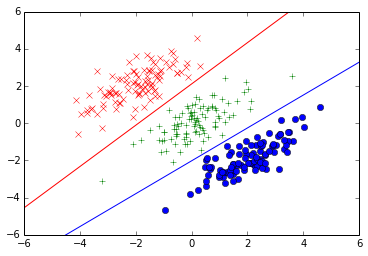

In [6]:
# 4.3.4 多类别逻辑回归

N = 300  # 数据的数目
M = 3    # 参数的维度
K = 3    # 类别的数目

def sigmoid(a):
    return 1 / (1 + np.exp(-a))

def f(x1, W_t, c1, c2):
    # 类别C1和类别C2的决策边界的直线方程
    a = - ((W_t[c1, 1] - W_t[c2, 1]) / (W_t[c1, 2] - W_t[c2, 2]))
    b = - ((W_t[c1, 0] - W_t[c2, 0]) / (W_t[c1, 2] - W_t[c2, 2]))
    return a * x1 + b

# 生成训练数据
cls1 = []
cls2 = []
cls3 = []

mean1 = [-2, 2]  # 类别1的均值
mean2 = [0, 0]   # 类别2的均值
mean3 = [2, -2]   # 类别3的均值
cov = [[1.0,0.8], [0.8,1.0]]  # 公用协方差矩阵

# 假定训练数据满足多维高斯分布
cls1.extend(np.random.multivariate_normal(mean1, cov, N / 3))
cls2.extend(np.random.multivariate_normal(mean2, cov, N / 3))
cls3.extend(np.random.multivariate_normal(mean3, cov, N / 3))

# 生成输入矩阵X
temp = vstack((cls1, cls2, cls3))
temp2 = ones((N, 1))
X = hstack((temp2, temp))

# 生成target 矩阵T （采用1-of-K的表示方法）
T = []
for i in range(N / 3):
    T.append(array([1, 0, 0]))
for i in range(N / 3):
    T.append(array([0, 1, 0]))
for i in range(N / 3):
    T.append(array([0, 0, 1]))
T = array(T)

# 利用IRLS算法更新参数矩阵W
turn = 0
W = np.zeros((M, K))
while True:
    # 由于没有使用固定基函数，phi恒等于X
    phi = X

    # 计算预测矩阵Y
    Y = np.zeros((N, K))
    for n in range(N):
        denominator = 0.0
        for k in range(K):
            denominator += np.exp(np.dot(W[:,k], X[n,:]))
        for k in range(K):
            Y[n, k] = np.exp(np.dot(W[:,k], X[n,:])) / denominator

    # 计算海森矩阵H
    I = np.identity(K)
    H = np.zeros((K * K, M, M))
    for j in range(K):
        for k in range(K):
            # 按照4.110式子来计算
            for n in range(N):
                temp = Y[n, k] * (I[k, j] - Y[n,j])
                H[k + j * K] += temp * matrix(phi)[n].reshape(M,1) * matrix(phi)[n].reshape(1,M)  # 
            # 也可以按照如下矩阵来进行计算
                #Ijk = 1 if j == k else 0
                #R = np.diag(Y[:,k] * (Ijk - Y[:,j]))
                #H[k + j * K] = np.dot(phi.T, np.dot(R, phi))

    # 更新权重矩阵W
    W_new = np.zeros((M, K))
    phi_T = phi.T
    for i in range(K):
        temp = np.dot(phi_T, Y[:,i] - T[:,i])
        W_new[:,i] = W[:,i] - np.dot(np.linalg.inv(H[i + i * K]), temp)

    # 判断W是否收敛
    diff = np.linalg.norm(W_new - W) / np.linalg.norm(W)
    if diff < 0.1: break

    W = W_new
    turn += 1

W_t = np.transpose(W)

# 绘制训练数据点
x1, x2 = np.transpose(np.array(cls1))
plot(x1, x2, 'rx')
x1, x2 = np.transpose(np.array(cls2))
plot(x1, x2, 'g+')
x1, x2 = np.transpose(np.array(cls3))
plot(x1, x2, 'bo')

# 绘制类别C1和类别C2的决策边界
x1 = np.linspace(-6, 6, 1000)
x2 = [f(x, W_t, 0, 1) for x in x1]
plot(x1, x2, 'r-')

# 绘制类别C2和类别C3的决策边界
x1 = np.linspace(-6, 6, 1000)
x2 = [f(x, W_t, 1, 2) for x in x1]
plot(x1, x2, 'b-')

xlim(-6, 6)
ylim(-6, 6)
show()

In [7]:
plt.scatter?